In [29]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import time

In [30]:
def load_image(path, size=(28, 28)):
    img = Image.open(path)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
    return img_array.flatten()  # shape: (2352,)

In [31]:
train_folder = "data/train"
X_train = []
y_train = []

# Loop through each class folder
for class_id in sorted(os.listdir(train_folder)):
    class_path = os.path.join(train_folder, class_id)
    if not os.path.isdir(class_path):
        continue
    label = int(class_id)
    for fname in os.listdir(class_path):
        img_path = os.path.join(class_path, fname)
        try:
            img_vector = load_image(img_path)
            X_train.append(img_vector)
            y_train.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

X_train = np.array(X_train)
y_train = np.array(y_train)
print("Loaded train images:", X_train.shape, "Labels:", y_train.shape)


Loaded train images: (26640, 2352) Labels: (26640,)


In [32]:
test_folder = "data/test"
test_labels_df = pd.read_csv("data/test_labels.csv")

X_test = []
y_test = []

for _, row in tqdm(test_labels_df.iterrows(), total=len(test_labels_df)):
    fname = row["image"]
    label = row["label"]
    img_path = os.path.join(test_folder, fname)
    # print(img_path,label)
    
    try:
        img_vector = load_image(img_path)
        X_test.append(img_vector)
        y_test.append(label)
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

X_test = np.array(X_test)
y_test = np.array(y_test)
print("Loaded test images:", X_test.shape, "Labels:", y_test.shape)


  0%|          | 0/12630 [00:00<?, ?it/s]

Loaded test images: (12630, 2352) Labels: (12630,)


In [53]:
import numpy as np

class NeuralNetwork:
    def __init__(self, n_features, hidden_layers, n_classes, learning_rate=0.01, batch_size=32,activation='sigmoid'):
        """
        Initialize the neural network
        
        Parameters:
        n_features (int): Number of input features
        hidden_layers (list): List of integers representing number of neurons in each hidden layer
        n_classes (int): Number of output classes
        learning_rate (float): Learning rate for weight updates
        batch_size (int): Mini-batch size for SGD
        """
        self.n_features = n_features
        self.hidden_layers = hidden_layers
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation_name = activation
        
        # Initialize network architecture
        self.architecture = [n_features] + hidden_layers + [n_classes]
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        # Xavier/Glorot initialization for weights
        for i in range(len(self.architecture) - 1):
            # Initialize weights with Xavier/Glorot initialization
            w = np.random.randn(self.architecture[i], self.architecture[i+1]) * np.sqrt(2 / (self.architecture[i] + self.architecture[i+1]))
            b = np.zeros((1, self.architecture[i+1]))
            
            self.weights.append(w)
            self.biases.append(b)
    
    def sigmoid(self, x):
        """Sigmoid activation function"""
        # Clip to avoid overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)
    
    def relu(self,x):
        return np.maximum(0, x)

    def relu_derivative(self,x):
        return (x > 0).astype(float)
    
    def softmax(self, x):
        """Softmax activation function"""
        # Subtract max for numerical stability
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """
        Forward propagation
        
        Parameters:
        X (numpy.ndarray): Input data of shape (batch_size, n_features)
        
        Returns:
        activations (list): List of activations at each layer
        net_inputs (list): List of net inputs at each layer
        """
        activations = [X]  # List to store activations of each layer
        net_inputs = []    # List to store net inputs to each layer
        
        # Hidden layers (sigmoid activation)
        for i in range(len(self.hidden_layers)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            net_inputs.append(z)
            if self.activation_name == 'relu':
                a = self.relu(z)
            else:
                a = self.sigmoid(z)
            activations.append(a)
        
        # Output layer (softmax activation)
        z_out = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        net_inputs.append(z_out)
        output = self.softmax(z_out)
        activations.append(output)
        
        return activations, net_inputs
    
    def cross_entropy_loss(self, y_true, y_pred):
        """
        Compute cross entropy loss
        
        Parameters:
        y_true (numpy.ndarray): One-hot encoded true labels
        y_pred (numpy.ndarray): Predicted probabilities from softmax
        
        Returns:
        float: Average cross entropy loss
        """
        # Add small epsilon to avoid log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Cross entropy loss
        log_likelihood = -np.sum(y_true * np.log(y_pred))
        loss = log_likelihood / y_true.shape[0]
        return loss
    
    def backward(self, X, y, activations, net_inputs):
        """
        Backward propagation to compute gradients
        
        Parameters:
        X (numpy.ndarray): Input data
        y (numpy.ndarray): One-hot encoded true labels
        activations (list): Activations from forward pass
        net_inputs (list): Net inputs from forward pass
        
        Returns:
        tuple: (weight_gradients, bias_gradients)
        """
        m = X.shape[0]  # Batch size
        
        # Initialize gradients
        weight_gradients = [np.zeros_like(w) for w in self.weights]
        bias_gradients = [np.zeros_like(b) for b in self.biases]
        
        # Output layer gradient calculation
        # delta_L = (output_activations - true_labels)
        delta = activations[-1] - y
        
        # Backpropagate through the network
        for layer in range(len(self.architecture) - 2, -1, -1):
            # Calculate gradients for current layer
            weight_gradients[layer] = np.dot(activations[layer].T, delta) / m
            bias_gradients[layer] = np.sum(delta, axis=0, keepdims=True) / m
            
            # Backpropagate error to previous layer (if not the input layer)
            if layer > 0:
                dA_prev = np.dot(delta, self.weights[layer].T)
                if self.activation_name == 'relu':
                    dZ = dA_prev * self.relu_derivative(net_inputs[layer - 1])
                else:
                    dZ = dA_prev * self.sigmoid_derivative(activations[layer])
                delta = dZ
        
        return weight_gradients, bias_gradients
    
    def update_parameters(self, weight_gradients, bias_gradients):
        """
        Update weights and biases using gradients
        
        Parameters:
        weight_gradients (list): Gradients for weights
        bias_gradients (list): Gradients for biases
        """
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * weight_gradients[i]
            self.biases[i] -= self.learning_rate * bias_gradients[i]
    
    def train_batch(self, X_batch, y_batch):
        """
        Train on a single mini-batch
        
        Parameters:
        X_batch (numpy.ndarray): Input batch data
        y_batch (numpy.ndarray): One-hot encoded batch labels
        
        Returns:
        float: Loss for this batch
        """
        # Forward pass
        activations, net_inputs = self.forward(X_batch)
        
        # Calculate loss
        loss = self.cross_entropy_loss(y_batch, activations[-1])
        
        # Backward pass
        weight_grads, bias_grads = self.backward(X_batch, y_batch, activations, net_inputs)
        
        # Update parameters
        self.update_parameters(weight_grads, bias_grads)
        
        return loss
    
    def train(self, X_train, y_train, epochs=100, verbose=True,adaptive_lr=False):
        """
        Train the neural network using mini-batch SGD
        
        Parameters:
        X_train (numpy.ndarray): Training data
        y_train (numpy.ndarray): One-hot encoded training labels
        epochs (int): Number of training epochs
        verbose (bool): Whether to print progress
        
        Returns:
        list: Training history (losses)
        """
        m = X_train.shape[0]
        train_losses = []
        tol = 1e-6
        prev_loss = None
        
        for epoch in range(epochs):
            # Shuffle training data
            if adaptive_lr:
                current_lr = self.learning_rate / np.sqrt(epoch + 1)
            else:
                current_lr = self.learning_rate
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Mini-batch training
            num_batches = int(np.ceil(m / self.batch_size))
            epoch_loss = 0
            
            for batch in range(num_batches):
                start_idx = batch * self.batch_size
                end_idx = min((batch + 1) * self.batch_size, m)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                activations, net_inputs = self.forward(X_batch)
                loss = self.cross_entropy_loss(y_batch, activations[-1])
                weight_grads, bias_grads = self.backward(X_batch, y_batch, activations, net_inputs)

                # Use current (adaptive) learning rate for updates
                for i in range(len(self.weights)):
                    self.weights[i] -= current_lr * weight_grads[i]
                    self.biases[i] -= current_lr * bias_grads[i]
                
                epoch_loss += loss
            
            # Average loss for the epoch
            avg_epoch_loss = epoch_loss / num_batches
            train_losses.append(avg_epoch_loss)
            
            if verbose and (epoch % 10 == 0):
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}")
                
            if prev_loss is not None and abs(prev_loss - avg_epoch_loss) < tol:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1} (Δloss < {tol})")
                break

        prev_loss = avg_epoch_loss
                
        return {"train_losses": train_losses}
    
    def predict(self, X):
        """
        Predict class probabilities for input data
        
        Parameters:
        X (numpy.ndarray): Input data
        
        Returns:
        numpy.ndarray: Predicted class probabilities
        """
        activations, _ = self.forward(X)
        return activations[-1]
    
    def predict_classes(self, X):
        """
        Predict class labels for input data
        
        Parameters:
        X (numpy.ndarray): Input data
        
        Returns:
        numpy.ndarray: Predicted class labels
        """
        probabilities = self.predict(X)
        return np.argmax(probabilities, axis=1)
    
    def evaluate(self, X, y):
        """
        Evaluate the model on data
        
        Parameters:
        X (numpy.ndarray): Input data
        y (numpy.ndarray): True labels (one-hot encoded)
        
        Returns:
        float: Accuracy
        """
        predictions = self.predict_classes(X)
        true_labels = np.argmax(y, axis=1) if len(y.shape) > 1 else y
        accuracy = np.mean(predictions == true_labels)
        return accuracy

# Utility function to convert labels to one-hot encoding
def to_one_hot(y, num_classes):
    """
    Convert integer labels to one-hot encoded vectors
    
    Parameters:
    y (numpy.ndarray): Array of integer labels
    num_classes (int): Number of classes
    
    Returns:
    numpy.ndarray: One-hot encoded labels
    """
    return np.eye(num_classes)[y]

In [66]:
n_samples, n_features = X_train.shape
n_classes = len(np.unique(y_train))

print(f"Training samples: {n_samples}")
print(f"Features: {n_features}")
print(f"Classes: {n_classes}")

# Convert labels to one-hot encoding
y_train_one_hot = to_one_hot(y_train, n_classes)

# Stopping criterion: fixed number of epochs
epochs = 200

hidden_units = [1, 5, 10, 50, 100]
results = []

for units in hidden_units:
    print(f"\nTraining with {units} hidden units")
    
    # Create neural network
    nn = NeuralNetwork(
        n_features=n_features,
        hidden_layers=[units],  # Single hidden layer
        n_classes=n_classes,
        learning_rate=0.01,
        batch_size=32
    )
    
    # Measure training time
    start_time = time.time()
    
    # Train the network
    history = nn.train(
        X_train=X_train,
        y_train=y_train_one_hot,
        epochs=epochs,
        verbose=True
    )
    
    train_time = time.time() - start_time
    print(f"Training time: {train_time:.2f} seconds")
    
    # Make predictions
    y_train_pred = nn.predict_classes(X_train)
    y_test_pred = nn.predict_classes(X_test)
    
    # Full metrics (train)
    train_report = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
    test_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("Train Metrics:")
    print(f"  Accuracy       : {train_accuracy:.4f}")
    print(f"  Macro Precision: {train_report['macro avg']['precision']:.4f}")
    print(f"  Macro Recall   : {train_report['macro avg']['recall']:.4f}")
    print(f"  Macro F1       : {train_report['macro avg']['f1-score']:.4f}")
    print(f"  Weighted F1    : {train_report['weighted avg']['f1-score']:.4f}")

    print("Test Metrics:")
    print(f"  Accuracy       : {test_accuracy:.4f}")
    print(f"  Macro Precision: {test_report['macro avg']['precision']:.4f}")
    print(f"  Macro Recall   : {test_report['macro avg']['recall']:.4f}")
    print(f"  Macro F1       : {test_report['macro avg']['f1-score']:.4f}")
    print(f"  Weighted F1    : {test_report['weighted avg']['f1-score']:.4f}")
    
    results.append({
        'hidden_units': units,
        'train_accuracy': train_accuracy,
        'train_macro_precision': train_report['macro avg']['precision'],
        'train_macro_recall': train_report['macro avg']['recall'],
        'train_macro_f1': train_report['macro avg']['f1-score'],
        'train_weighted_f1': train_report['weighted avg']['f1-score'],
        'test_accuracy': test_accuracy,
        'test_macro_precision': test_report['macro avg']['precision'],
        'test_macro_recall': test_report['macro avg']['recall'],
        'test_macro_f1': test_report['macro avg']['f1-score'],
        'test_weighted_f1': test_report['weighted avg']['f1-score'],
        'train_time': train_time,
        'train_per_class': {k: v for k, v in train_report.items() if k.isdigit()},
        'test_per_class': {k: v for k, v in test_report.items() if k.isdigit()}
    })

Training samples: 26640
Features: 2352
Classes: 43

Training with 1 hidden units
Epoch 1/200, Loss: 3.7138
Epoch 11/200, Loss: 3.4610
Epoch 21/200, Loss: 3.3108
Epoch 31/200, Loss: 3.1995
Epoch 41/200, Loss: 3.1300
Epoch 51/200, Loss: 3.0799
Epoch 61/200, Loss: 3.0437
Epoch 71/200, Loss: 3.0173
Epoch 81/200, Loss: 2.9976
Epoch 91/200, Loss: 2.9820
Epoch 101/200, Loss: 2.9690
Epoch 111/200, Loss: 2.9582
Epoch 121/200, Loss: 2.9489
Epoch 131/200, Loss: 2.9408
Epoch 141/200, Loss: 2.9342
Epoch 151/200, Loss: 2.9280
Epoch 161/200, Loss: 2.9225
Epoch 171/200, Loss: 2.9171
Epoch 181/200, Loss: 2.9125
Epoch 191/200, Loss: 2.9085
Training time: 91.27 seconds
Train Metrics:
  Accuracy       : 0.1212
  Macro Precision: 0.0130
  Macro Recall   : 0.0516
  Macro F1       : 0.0188
  Weighted F1    : 0.0434
Test Metrics:
  Accuracy       : 0.1305
  Macro Precision: 0.0141
  Macro Recall   : 0.0530
  Macro F1       : 0.0204
  Weighted F1    : 0.0492

Training with 5 hidden units
Epoch 1/200, Loss: 3.6

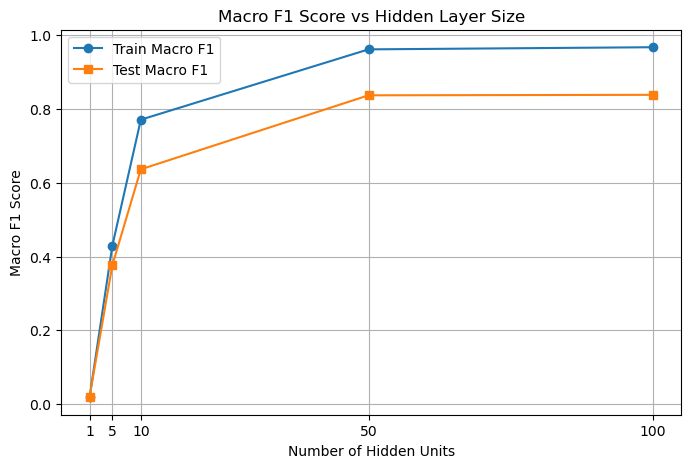

In [67]:
import matplotlib.pyplot as plt

hidden_units = [r['hidden_units'] for r in results]
train_macro_f1 = [r['train_macro_f1'] for r in results]
test_macro_f1 = [r['test_macro_f1'] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(hidden_units, train_macro_f1, marker='o', label='Train Macro F1')
plt.plot(hidden_units, test_macro_f1, marker='s', label='Test Macro F1')
plt.xlabel("Number of Hidden Units")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Score vs Hidden Layer Size")
plt.grid(True)
plt.legend()
plt.xticks(hidden_units)
plt.show()

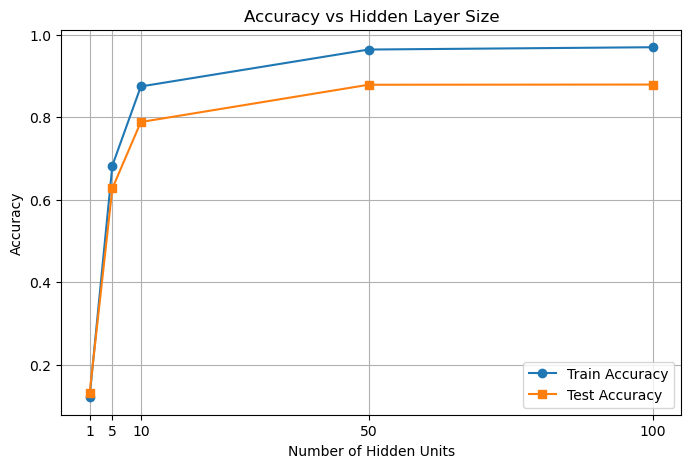

In [68]:
train_acc = [r['train_accuracy'] for r in results]
test_acc = [r['test_accuracy'] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(hidden_units, train_acc, marker='o', label='Train Accuracy')
plt.plot(hidden_units, test_acc, marker='s', label='Test Accuracy')
plt.xlabel("Number of Hidden Units")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Hidden Layer Size")
plt.grid(True)
plt.legend()
plt.xticks(hidden_units)
plt.show()


part c

In [69]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

def run_depth_experiment_with_metrics(X_train, y_train, X_test, y_test, hidden_layer_configs, epochs=100):
    y_train_oh = to_one_hot(y_train, num_classes=43)
    all_metrics = []

    for i, hidden_layers in enumerate(hidden_layer_configs):
        print(f"\nTraining model {i+1} with hidden layers: {hidden_layers}")
        model = NeuralNetwork(n_features=X_train.shape[1],
                              hidden_layers=hidden_layers,
                              n_classes=43,
                              learning_rate=0.01,
                              batch_size=32)
        
        model.train(X_train, y_train_oh, epochs=epochs, verbose=True)
        y_pred = model.predict_classes(X_test)

        # Collect metrics
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        avg_macro_f1 = report['macro avg']['f1-score']
        avg_macro_precision = report['macro avg']['precision']
        avg_macro_recall = report['macro avg']['recall']
        weighted_f1 = report['weighted avg']['f1-score']
        overall_accuracy = report['accuracy']

        # Store all metrics
        metrics = {
            "hidden_layers": hidden_layers,
            "macro_precision": avg_macro_precision,
            "macro_recall": avg_macro_recall,
            "macro_f1": avg_macro_f1,
            "weighted_f1": weighted_f1,
            "accuracy": overall_accuracy,
            "per_class": {k: v for k, v in report.items() if k.isdigit()}  # only class-wise metrics
        }
        all_metrics.append(metrics)

        print(f"Accuracy: {overall_accuracy:.4f} | Macro F1: {avg_macro_f1:.4f} | Weighted F1: {weighted_f1:.4f}")

    return all_metrics


In [70]:
# Define architectures to try
hidden_layer_configs = [
    [512],
    [512, 256],
    [512, 256, 128],
    [512, 256, 128, 64]
]

# Run the experiment
fixed_lr_results = run_depth_experiment_with_metrics(X_train, y_train, X_test, y_test, hidden_layer_configs, epochs=100)





Training model 1 with hidden layers: [512]
Epoch 1/100, Loss: 3.2855
Epoch 11/100, Loss: 1.4434
Epoch 21/100, Loss: 0.9153
Epoch 31/100, Loss: 0.6763
Epoch 41/100, Loss: 0.5425
Epoch 51/100, Loss: 0.4585
Epoch 61/100, Loss: 0.4010
Epoch 71/100, Loss: 0.3585
Epoch 81/100, Loss: 0.3262
Epoch 91/100, Loss: 0.3006
Accuracy: 0.8580 | Macro F1: 0.8102 | Weighted F1: 0.8560

Training model 2 with hidden layers: [512, 256]
Epoch 1/100, Loss: 3.4892
Epoch 11/100, Loss: 2.4303
Epoch 21/100, Loss: 1.5612
Epoch 31/100, Loss: 1.0531
Epoch 41/100, Loss: 0.7729
Epoch 51/100, Loss: 0.6106
Epoch 61/100, Loss: 0.5064
Epoch 71/100, Loss: 0.4348
Epoch 81/100, Loss: 0.3826
Epoch 91/100, Loss: 0.3430
Accuracy: 0.8443 | Macro F1: 0.7741 | Weighted F1: 0.8429

Training model 3 with hidden layers: [512, 256, 128]
Epoch 1/100, Loss: 3.5326
Epoch 11/100, Loss: 3.3895
Epoch 21/100, Loss: 2.8932
Epoch 31/100, Loss: 2.0651
Epoch 41/100, Loss: 1.5197
Epoch 51/100, Loss: 1.1871
Epoch 61/100, Loss: 0.9664
Epoch 71/10

In [81]:
fixed_lr_results

[{'hidden_layers': [512],
  'macro_precision': 0.8602377415733523,
  'macro_recall': 0.7875231372567065,
  'macro_f1': 0.8101727990398611,
  'weighted_f1': 0.8559867224222045,
  'accuracy': 0.857957244655582,
  'per_class': {'0': {'precision': 0.9130434782608695,
    'recall': 0.35,
    'f1-score': 0.5060240963855421,
    'support': 60.0},
   '1': {'precision': 0.7282608695652174,
    'recall': 0.9305555555555556,
    'f1-score': 0.8170731707317073,
    'support': 720.0},
   '2': {'precision': 0.8705722070844687,
    'recall': 0.852,
    'f1-score': 0.8611859838274932,
    'support': 750.0},
   '3': {'precision': 0.7896825396825397,
    'recall': 0.8844444444444445,
    'f1-score': 0.8343815513626834,
    'support': 450.0},
   '4': {'precision': 0.8616852146263911,
    'recall': 0.8212121212121212,
    'f1-score': 0.8409619860356866,
    'support': 660.0},
   '5': {'precision': 0.7830319888734353,
    'recall': 0.8936507936507937,
    'f1-score': 0.8346923647146034,
    'support': 630.

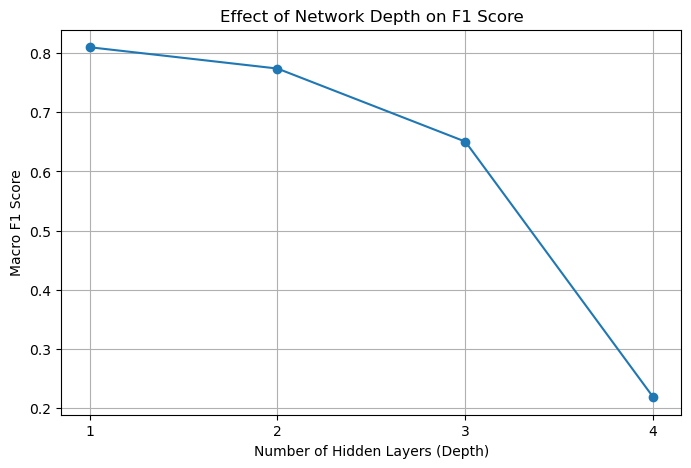

In [71]:
# Fix the f1_scores to pull only macro F1s from each result dict
f1_values = [r['macro_f1'] for r in fixed_lr_results]  # assuming each r is a dict

plt.figure(figsize=(8, 5))
depths = [len(cfg) for cfg in hidden_layer_configs]
plt.plot(depths, f1_values, marker='o', linestyle='-')
plt.xlabel("Number of Hidden Layers (Depth)")
plt.ylabel("Macro F1 Score")
plt.title("Effect of Network Depth on F1 Score")
plt.grid(True)
plt.xticks(depths)
plt.show()

part d

In [72]:
def run_adaptive_depth_experiment(X_train, y_train, X_test, y_test, hidden_layer_configs, epochs=100):
    y_train_oh = to_one_hot(y_train, num_classes=43)
    all_metrics = []

    for i, hidden_layers in enumerate(hidden_layer_configs):
        print(f"\nAdaptive LR model {i+1} with hidden layers: {hidden_layers}")
        model = NeuralNetwork(n_features=X_train.shape[1],
                              hidden_layers=hidden_layers,
                              n_classes=43,
                              learning_rate=0.01,
                              batch_size=32)
        
        model.train(X_train, y_train_oh, epochs=epochs, verbose=True, adaptive_lr=True)
        y_pred = model.predict_classes(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        avg_f1 = report['macro avg']['f1-score']
        acc = report['accuracy']

        print(f"Accuracy: {acc:.4f} | Macro F1: {avg_f1:.4f}")

        all_metrics.append({
            "hidden_layers": hidden_layers,
            "macro_f1": avg_f1,
            "accuracy": acc,
            "report": report
        })

    return all_metrics



Adaptive LR model 1 with hidden layers: [512]
Epoch 1/100, Loss: 3.2713
Epoch 11/100, Loss: 2.0523
Epoch 21/100, Loss: 1.7115
Epoch 31/100, Loss: 1.5106
Epoch 41/100, Loss: 1.3717
Epoch 51/100, Loss: 1.2673
Epoch 61/100, Loss: 1.1855
Epoch 71/100, Loss: 1.1188
Epoch 81/100, Loss: 1.0638
Epoch 91/100, Loss: 1.0163
Accuracy: 0.7214 | Macro F1: 0.6031

Adaptive LR model 2 with hidden layers: [512, 256]
Epoch 1/100, Loss: 3.4870
Epoch 11/100, Loss: 3.1255
Epoch 21/100, Loss: 2.7826
Epoch 31/100, Loss: 2.4961
Epoch 41/100, Loss: 2.2936
Epoch 51/100, Loss: 2.1405
Epoch 61/100, Loss: 2.0160
Epoch 71/100, Loss: 1.9095
Epoch 81/100, Loss: 1.8159
Epoch 91/100, Loss: 1.7323
Accuracy: 0.5006 | Macro F1: 0.2873

Adaptive LR model 3 with hidden layers: [512, 256, 128]
Epoch 1/100, Loss: 3.5273
Epoch 11/100, Loss: 3.4733
Epoch 21/100, Loss: 3.4485
Epoch 31/100, Loss: 3.4189
Epoch 41/100, Loss: 3.3894
Epoch 51/100, Loss: 3.3613
Epoch 61/100, Loss: 3.3292
Epoch 71/100, Loss: 3.2858
Epoch 81/100, Loss:

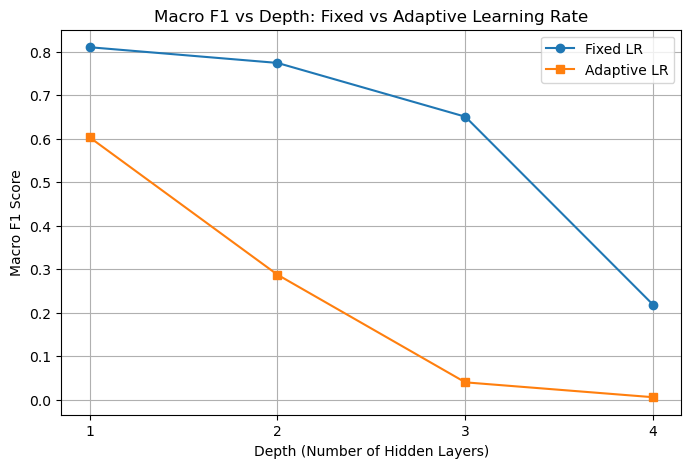

In [73]:
# Run both and compare
depths = [1, 2, 3, 4]

adaptive_lr_results = run_adaptive_depth_experiment(X_train, y_train, X_test, y_test, hidden_layer_configs)

plt.figure(figsize=(8, 5))
plt.plot(depths, [r['macro_f1'] for r in fixed_lr_results], marker='o', label="Fixed LR")
plt.plot(depths, [r['macro_f1'] for r in adaptive_lr_results], marker='s', label="Adaptive LR")
plt.xlabel("Depth (Number of Hidden Layers)")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 vs Depth: Fixed vs Adaptive Learning Rate")
plt.grid(True)
plt.legend()
plt.xticks(depths)
plt.show()


In [82]:
adaptive_lr_results

[{'hidden_layers': [512],
  'macro_f1': 0.6031332571803353,
  'accuracy': 0.7213776722090262,
  'report': {'0': {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 60.0},
   '1': {'precision': 0.7412333736396615,
    'recall': 0.8513888888888889,
    'f1-score': 0.7925016160310278,
    'support': 720.0},
   '2': {'precision': 0.6970899470899471,
    'recall': 0.7026666666666667,
    'f1-score': 0.699867197875166,
    'support': 750.0},
   '3': {'precision': 0.5878661087866108,
    'recall': 0.6244444444444445,
    'f1-score': 0.6056034482758621,
    'support': 450.0},
   '4': {'precision': 0.6733238231098431,
    'recall': 0.7151515151515152,
    'f1-score': 0.6936076414401176,
    'support': 660.0},
   '5': {'precision': 0.4864516129032258,
    'recall': 0.5984126984126984,
    'f1-score': 0.5366548042704626,
    'support': 630.0},
   '6': {'precision': 0.5987654320987654,
    'recall': 0.6466666666666666,
    'f1-score': 0.6217948717948718,
    'support': 150.0}

part e

In [74]:
def run_relu_depth_experiment(X_train, y_train, X_test, y_test, hidden_layer_configs, epochs=100, tol=1e-6):
    y_train_oh = to_one_hot(y_train, num_classes=43)
    all_metrics = []

    for i, hidden_layers in enumerate(hidden_layer_configs):
        print(f"\nReLU model {i+1} with hidden layers: {hidden_layers}")
        model = NeuralNetwork(n_features=X_train.shape[1],
                              hidden_layers=hidden_layers,
                              n_classes=43,
                              learning_rate=0.01,
                              batch_size=32,
                              activation='relu')
        
        model.train(X_train, y_train_oh, epochs=epochs, verbose=True, adaptive_lr=True)
        y_pred = model.predict_classes(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        avg_f1 = report['macro avg']['f1-score']
        acc = report['accuracy']

        print(f"Accuracy: {acc:.4f} | Macro F1: {avg_f1:.4f}")

        all_metrics.append({
            "hidden_layers": hidden_layers,
            "macro_f1": avg_f1,
            "accuracy": acc,
            "report": report
        })

    return all_metrics



ReLU model 1 with hidden layers: [512]
Epoch 1/100, Loss: 2.5485
Epoch 11/100, Loss: 0.7245
Epoch 21/100, Loss: 0.5481
Epoch 31/100, Loss: 0.4690
Epoch 41/100, Loss: 0.4215
Epoch 51/100, Loss: 0.3886
Epoch 61/100, Loss: 0.3643
Epoch 71/100, Loss: 0.3457
Epoch 81/100, Loss: 0.3300
Epoch 91/100, Loss: 0.3168
Accuracy: 0.8572 | Macro F1: 0.8137

ReLU model 2 with hidden layers: [512, 256]
Epoch 1/100, Loss: 2.5554
Epoch 11/100, Loss: 0.4831
Epoch 21/100, Loss: 0.3464
Epoch 31/100, Loss: 0.2910
Epoch 41/100, Loss: 0.2588
Epoch 51/100, Loss: 0.2369
Epoch 61/100, Loss: 0.2207
Epoch 71/100, Loss: 0.2079
Epoch 81/100, Loss: 0.1972
Epoch 91/100, Loss: 0.1883
Accuracy: 0.8698 | Macro F1: 0.8239

ReLU model 3 with hidden layers: [512, 256, 128]
Epoch 1/100, Loss: 2.6058
Epoch 11/100, Loss: 0.3813
Epoch 21/100, Loss: 0.2709
Epoch 31/100, Loss: 0.2254
Epoch 41/100, Loss: 0.1963
Epoch 51/100, Loss: 0.1770
Epoch 61/100, Loss: 0.1603
Epoch 71/100, Loss: 0.1486
Epoch 81/100, Loss: 0.1384
Epoch 91/100,

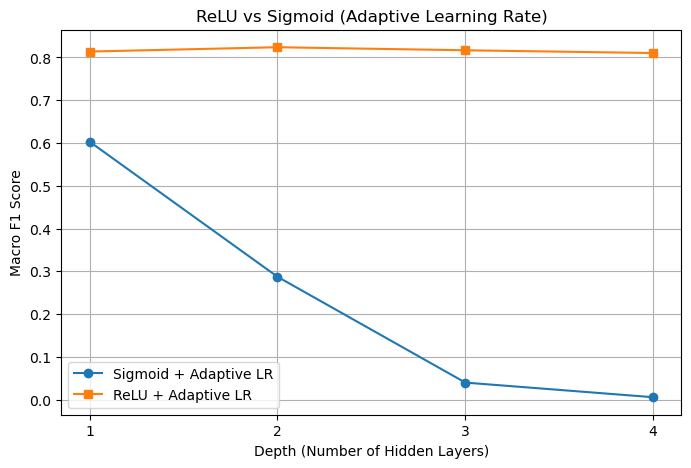

In [75]:
relu_results = run_relu_depth_experiment(X_train, y_train, X_test, y_test, hidden_layer_configs)

plt.figure(figsize=(8, 5))
plt.plot(depths, [r['macro_f1'] for r in adaptive_lr_results], marker='o', label="Sigmoid + Adaptive LR")
plt.plot(depths, [r['macro_f1'] for r in relu_results], marker='s', label="ReLU + Adaptive LR")
plt.xlabel("Depth (Number of Hidden Layers)")
plt.ylabel("Macro F1 Score")
plt.title("ReLU vs Sigmoid (Adaptive Learning Rate)")
plt.grid(True)
plt.legend()
plt.xticks(depths)
plt.show()


In [83]:
relu_results

[{'hidden_layers': [512],
  'macro_f1': 0.8137342717142578,
  'accuracy': 0.8572446555819477,
  'report': {'0': {'precision': 0.8214285714285714,
    'recall': 0.38333333333333336,
    'f1-score': 0.5227272727272727,
    'support': 60.0},
   '1': {'precision': 0.7638888888888888,
    'recall': 0.9166666666666666,
    'f1-score': 0.8333333333333334,
    'support': 720.0},
   '2': {'precision': 0.8423707440100883,
    'recall': 0.8906666666666667,
    'f1-score': 0.8658457550226831,
    'support': 750.0},
   '3': {'precision': 0.7907444668008048,
    'recall': 0.8733333333333333,
    'f1-score': 0.8299894403379092,
    'support': 450.0},
   '4': {'precision': 0.8240740740740741,
    'recall': 0.8090909090909091,
    'f1-score': 0.8165137614678899,
    'support': 660.0},
   '5': {'precision': 0.7546666666666667,
    'recall': 0.8984126984126984,
    'f1-score': 0.8202898550724638,
    'support': 630.0},
   '6': {'precision': 0.7194244604316546,
    'recall': 0.6666666666666666,
    'f1-sc

part f

In [76]:
from sklearn.neural_network import MLPClassifier

In [77]:
def run_sklearn_mlp_experiment(X_train, y_train, X_test, y_test, hidden_layer_configs, epochs=100):
    all_metrics = []

    for i, hidden_layers in enumerate(hidden_layer_configs):
        print(f"\nSklearn MLP {i+1} with layers: {hidden_layers}")
        clf = MLPClassifier(hidden_layer_sizes=tuple(hidden_layers),
                            activation='relu',
                            solver='sgd',
                            learning_rate='invscaling',
                            batch_size=32,
                            alpha=0,
                            max_iter=epochs,
                            random_state=42,
                            verbose=False)
        
        start_time = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time

        y_pred = clf.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        avg_f1 = report['macro avg']['f1-score']
        acc = report['accuracy']

        print(f"Accuracy: {acc:.4f} | Macro F1: {avg_f1:.4f}")

        all_metrics.append({
            "hidden_layers": hidden_layers,
            "macro_f1": avg_f1,
            "accuracy": acc,
            "weighted_f1": report['weighted avg']['f1-score'],
            "report": report,
            "train_time": train_time
        })

    return all_metrics


In [78]:
sklearn_mlp_results = run_sklearn_mlp_experiment(X_train, y_train, X_test, y_test, hidden_layer_configs)



Sklearn MLP 1 with layers: [512]


/home/anup/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5937 | Macro F1: 0.3997

Sklearn MLP 2 with layers: [512, 256]


/home/anup/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5884 | Macro F1: 0.4084

Sklearn MLP 3 with layers: [512, 256, 128]


/home/anup/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5702 | Macro F1: 0.3839

Sklearn MLP 4 with layers: [512, 256, 128, 64]


/home/anup/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.4875 | Macro F1: 0.2580


In [84]:
for result in sklearn_mlp_results:
    print(f"\nHidden Layers: {result['hidden_layers']}")
    print(f"Accuracy: {result['accuracy']:.4f} | Macro F1: {result['macro_f1']:.4f}")
    print(f"Train Time: {result['train_time']:.2f} seconds")
    print("Classification Report:")
    


Hidden Layers: [512]
Accuracy: 0.5937 | Macro F1: 0.3997
Train Time: 1160.83 seconds
Classification Report:

Hidden Layers: [512, 256]
Accuracy: 0.5884 | Macro F1: 0.4084
Train Time: 1514.73 seconds
Classification Report:

Hidden Layers: [512, 256, 128]
Accuracy: 0.5702 | Macro F1: 0.3839
Train Time: 1672.27 seconds
Classification Report:

Hidden Layers: [512, 256, 128, 64]
Accuracy: 0.4875 | Macro F1: 0.2580
Train Time: 1762.47 seconds
Classification Report:


In [85]:
sklearn_mlp_results

[{'hidden_layers': [512],
  'macro_f1': 0.3997423389102254,
  'accuracy': 0.5937450514647664,
  'weighted_f1': 0.5428703776416801,
  'report': {'0': {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 60.0},
   '1': {'precision': 0.6158256880733946,
    'recall': 0.7458333333333333,
    'f1-score': 0.6746231155778895,
    'support': 720.0},
   '2': {'precision': 0.42574981711777615,
    'recall': 0.776,
    'f1-score': 0.5498346717052432,
    'support': 750.0},
   '3': {'precision': 0.1536231884057971,
    'recall': 0.11777777777777777,
    'f1-score': 0.13333333333333333,
    'support': 450.0},
   '4': {'precision': 0.4876905041031653,
    'recall': 0.6303030303030303,
    'f1-score': 0.5499008592200926,
    'support': 660.0},
   '5': {'precision': 0.18505942275042445,
    'recall': 0.173015873015873,
    'f1-score': 0.17883511074651354,
    'support': 630.0},
   '6': {'precision': 1.0,
    'recall': 0.006666666666666667,
    'f1-score': 0.013245033112582781,
   

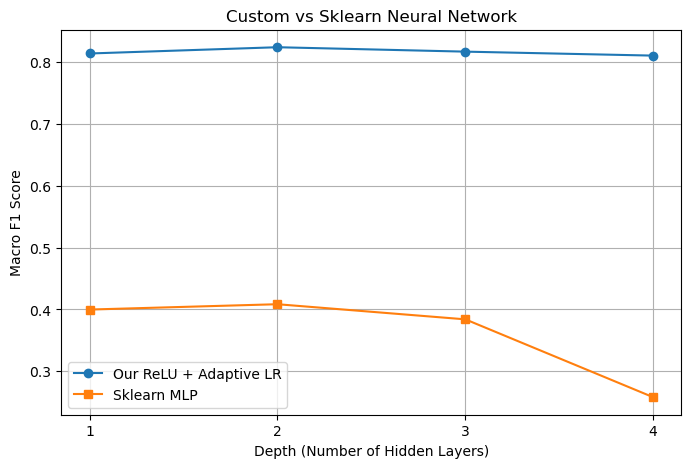

In [79]:
depths = [len(cfg) for cfg in hidden_layer_configs]

plt.figure(figsize=(8, 5))
plt.plot(depths, [r['macro_f1'] for r in relu_results], marker='o', label="Our ReLU + Adaptive LR")
plt.plot(depths, [r['macro_f1'] for r in sklearn_mlp_results], marker='s', label="Sklearn MLP")
plt.xlabel("Depth (Number of Hidden Layers)")
plt.ylabel("Macro F1 Score")
plt.title("Custom vs Sklearn Neural Network")
plt.grid(True)
plt.legend()
plt.xticks(depths)
plt.show()
